# Import Modules

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Simulate Stock Prices

In [2]:
def get_stock_prices_via_EM(s:float, sigma:float, T:float, dt:float, N:int) -> np.array:
    """ Simulate Stock Price SDE of dS_u = sigma * dW_u via the Euler Maruyama method """
    S = np.zeros(N + 1) # Initialize the Stock Price Array
    S[0] = s # First Stock Price
    dW = np.random.normal(0, np.sqrt(dt), N) # GBM increments
    for t in range(1, N+1):
        S[t] = S[t-1] + sigma*dW[t-1] # Simulate Stock Prices via the Euler Maruyama Method
    return S

def value_function(x: float, s: float, q: float, gamma: float, sigma: float, T: float, t: float) -> float:
    """Calculate the value function"""
    return -np.exp(-gamma * x) * np.exp(-gamma * q * s) * np.exp(gamma**2 * q**2 * sigma**2 * (T - t) / 2)

def reservation_bid_price(s: float, q: float, gamma: float, sigma: float, T: float, t: float) -> float:
    """Calculate the reservation bid price"""
    return s + (-1 - 2 * q) * gamma * sigma**2 * (T - t) / 2

def reservation_ask_price(s: float, q: float, gamma: float, sigma: float, T: float, t: float) -> float:
    """Calculate the reservation ask price"""
    return s + (1 - 2 * q) * gamma * sigma**2 * (T - t) / 2

def simulate_and_plot(S, sigma, T, dt, gamma, x, q):
    """
    Compute value function, reservation bid, and ask prices,
    and plot the results.

    Parameters:
        S (np.array): Simulated stock prices
        sigma (float): Volatility
        T (float): Time horizon
        dt (float): Time step
        gamma (float): Risk aversion parameter
        x (float): Initial wealth
        q (float): Inventory of stocks
    """
    N = len(S) - 1  # Number of time steps
    time_points = np.linspace(0, T, N+1)
    
    # Compute Value Function, Reservation Bid, and Ask Prices at each time step
    value_func = np.zeros(N+1)
    bid_prices = np.zeros(N+1)
    ask_prices = np.zeros(N+1)
    
    for t in range(N+1):
        current_time = t * dt
        value_func[t] = value_function(x, S[t], q, gamma, sigma, T, current_time)
        bid_prices[t] = reservation_bid_price(S[t], q, gamma, sigma, T, current_time)
        ask_prices[t] = reservation_ask_price(S[t], q, gamma, sigma, T, current_time)
    
    reservation_price = [(a + b) / 2 for a, b in zip(bid_prices, ask_prices)]
    
    return time_points, S, bid_prices, ask_prices, reservation_price, value_func

def stationary_reservation_ask_price(s: float, q: float, gamma: float, sigma: float, omega: float, epsilon=1e-8) -> float:
    """Calculate the stationary reservation ask price with a small epsilon to avoid log(0)"""
    term = (1 - 2 * q) * gamma**2 * sigma**2
    argument = 1 + term / (2 * omega - gamma**2 * q**2 * sigma**2 + epsilon)
    return s + (1/gamma) * np.log(argument)

def stationary_reservation_bid_price(s: float, q: float, gamma: float, sigma: float, omega: float, epsilon=1e-8) -> float:
    """Calculate the stationary reservation bid price with a small epsilon to avoid log(0)"""
    term = (-1 - 2 * q) * gamma**2 * sigma**2
    argument = 1 + term / (2 * omega - gamma**2 * q**2 * sigma**2 + epsilon)
    return s + (1/gamma) * np.log(argument)


def simulate_and_plot_infinite_horizon(S, sigma, gamma, x, q, omega):
    """Compute stationary reservation bid and ask prices, and plot the results.

    Parameters:
        S (np.array): Simulated stock prices
        sigma (float): Volatility
        gamma (float): Risk aversion parameter
        x (float): Initial wealth
        q (float): Inventory of stocks
        omega (float): Parameter to bound the inventory position
    """
    N = len(S) - 1  # Number of time steps
    time_points = np.linspace(0, T, N+1)
    
    # Compute Stationary Reservation Bid and Ask Prices at each time step
    bid_prices = np.zeros(N+1)
    ask_prices = np.zeros(N+1)
    
    for t in range(N+1):
        bid_prices[t] = stationary_reservation_bid_price(S[t], q, gamma, sigma, omega)
        ask_prices[t] = stationary_reservation_ask_price(S[t], q, gamma, sigma, omega)
    
    reservation_price = [(a + b) / 2 for a, b in zip(bid_prices, ask_prices)]
    
    return time_points, S, bid_prices, ask_prices, reservation_price

# Inactive Trader - Reservation Price

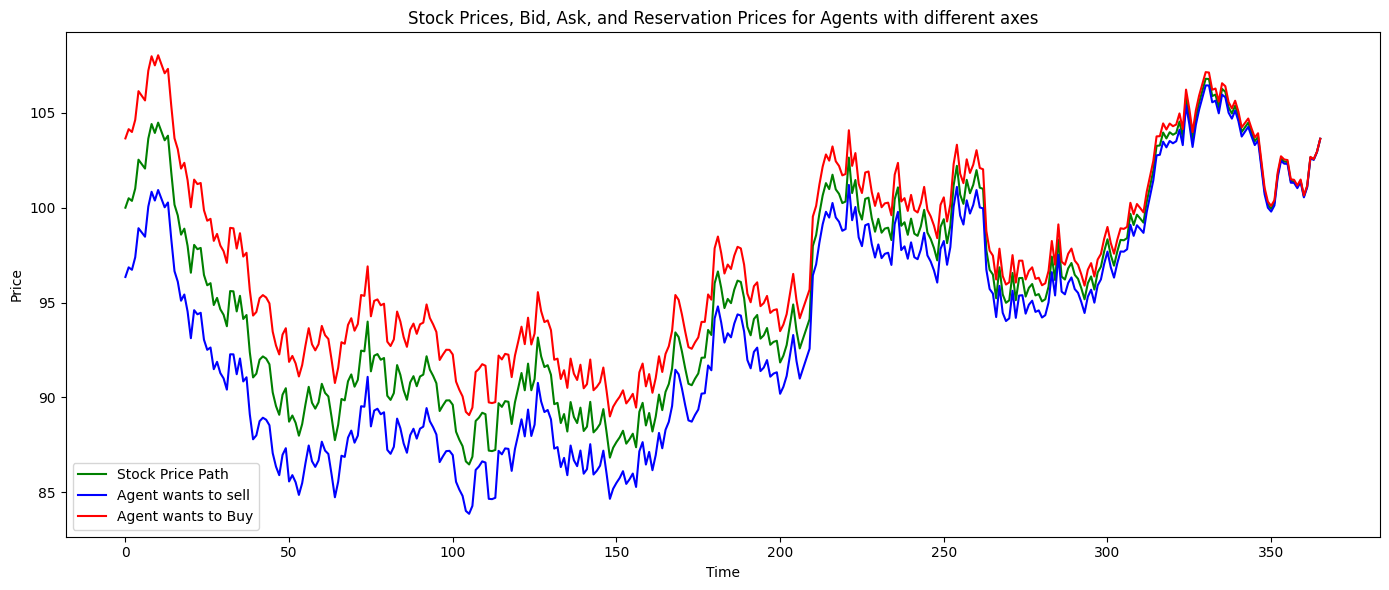

In [3]:
np.random.seed(42)

# Parameters
s = 100          # Initial Stock Price
sigma = 1        # Volatility
T = 365          # Time Horizon
dt = 1           # Time Steps
N = int(T/dt)    # Number of Time Steps
gamma = 0.01     # Risk Aversion Parameter
x = 100000       # Initial wealth
q_max = 1        # Maximum inventory position
omega = 0.5 * gamma**2 * sigma**2 * (q_max + 1)**2  # Setting omega based on the paper's suggestion


S = get_stock_prices_via_EM(s=s, sigma=sigma, T=T, dt=dt, N=N)

# Run the function for q = 1 and q = -1 with the same stock prices
time_points_1, S_1, bid_prices_1, ask_prices_1, reservation_price_1, value_func_1 = simulate_and_plot(
    S=S, sigma=sigma, T=T, dt=dt, gamma=gamma, x=x, q=1)

time_points_neg1, S_neg1, bid_prices_neg1, ask_prices_neg1, reservation_price_neg1, value_func_neg1 = simulate_and_plot(
    S=S, sigma=sigma, T=T, dt=dt, gamma=gamma, x=x, q=-1)

# Plot the results in a 2x2 grid
plt.figure(figsize=(14, 6))

# q = 1 Plots
plt.plot(time_points_1, S_1, label='Stock Price Path', color='green')
# plt.plot(time_points_1, bid_prices_1, label='Reservation Bid Price', color='green')
# plt.plot(time_points_1, ask_prices_1, label='Reservation Ask Price', color='red')
plt.plot(time_points_1, reservation_price_1, label="Agent wants to sell", color='blue')
plt.plot(time_points_neg1, reservation_price_neg1, label="Agent wants to Buy", color='red')
plt.title('Stock Prices, Bid, Ask, and Reservation Prices for Agents with different axes')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


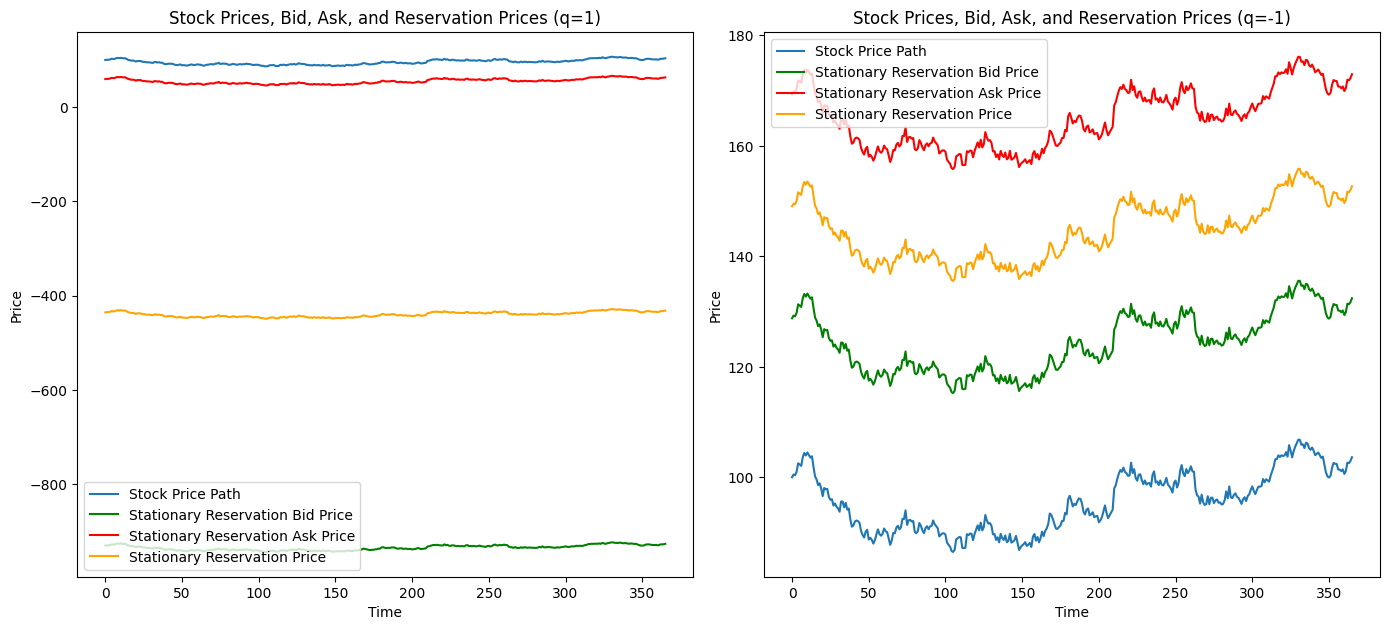

In [4]:
# Parameters
# Run the function for q = 1 and q = -1 with the same stock prices and infinite horizon adjustments
time_points_1, S_1, bid_prices_1, ask_prices_1, reservation_price_1 = simulate_and_plot_infinite_horizon(
    S=S, sigma=sigma, gamma=gamma, x=x, q=1, omega=omega)

time_points_neg1, S_neg1, bid_prices_neg1, ask_prices_neg1, reservation_price_neg1 = simulate_and_plot_infinite_horizon(
    S=S, sigma=sigma, gamma=gamma, x=x, q=-1, omega=omega)

# Plot the results in a 2x2 grid
plt.figure(figsize=(14, 12))

# q = 1 Plots
plt.subplot(2, 2, 1)
plt.plot(time_points_1, S_1, label='Stock Price Path')
plt.plot(time_points_1, bid_prices_1, label='Stationary Reservation Bid Price', color='green')
plt.plot(time_points_1, ask_prices_1, label='Stationary Reservation Ask Price', color='red')
plt.plot(time_points_1, reservation_price_1, label="Stationary Reservation Price", color='orange')
plt.title('Stock Prices, Bid, Ask, and Reservation Prices (q=1)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# q = -1 Plots
plt.subplot(2, 2, 2)
plt.plot(time_points_neg1, S_neg1, label='Stock Price Path')
plt.plot(time_points_neg1, bid_prices_neg1, label='Stationary Reservation Bid Price', color='green')
plt.plot(time_points_neg1, ask_prices_neg1, label='Stationary Reservation Ask Price', color='red')
plt.plot(time_points_neg1, reservation_price_neg1, label="Stationary Reservation Price", color='orange')
plt.title('Stock Prices, Bid, Ask, and Reservation Prices (q=-1)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()



In [5]:

def lambda_a(delta_a, k=1):
    """Intensity function for buy orders"""
    return np.exp(-k * delta_a)

def lambda_b(delta_b, k=1):
    """Intensity function for sell orders"""
    return np.exp(-k * delta_b)

def simulate_limit_orders(S, sigma, gamma, x, q, T, dt):
    N = len(S) - 1  # Number of time steps
    time_points = np.linspace(0, T, N+1)
    
    # Initialize variables for wealth and inventory
    wealth = np.zeros(N+1)
    inventory = np.zeros(N+1)
    
    for t in range(1, N+1):
        s = S[t]
        
        # Calculate the reservation prices
        reservation_ask = stationary_reservation_ask_price(s, q, gamma, sigma, omega)
        reservation_bid = stationary_reservation_bid_price(s, q, gamma, sigma, omega)
        
        # Calculate distances from mid-price
        delta_a = reservation_ask - s
        delta_b = s - reservation_bid
        
        # Calculate intensities
        lambda_a_val = lambda_a(delta_a)
        lambda_b_val = lambda_b(delta_b)
        
        # Simulate the Poisson process for buy/sell orders
        dNa = np.random.poisson(lambda_a_val * dt)
        dNb = np.random.poisson(lambda_b_val * dt)
        
        # Update wealth and inventory
        wealth[t] = wealth[t-1] + reservation_ask * dNa - reservation_bid * dNb
        inventory[t] = inventory[t-1] + dNb - dNa
    
    return time_points, wealth, inventory

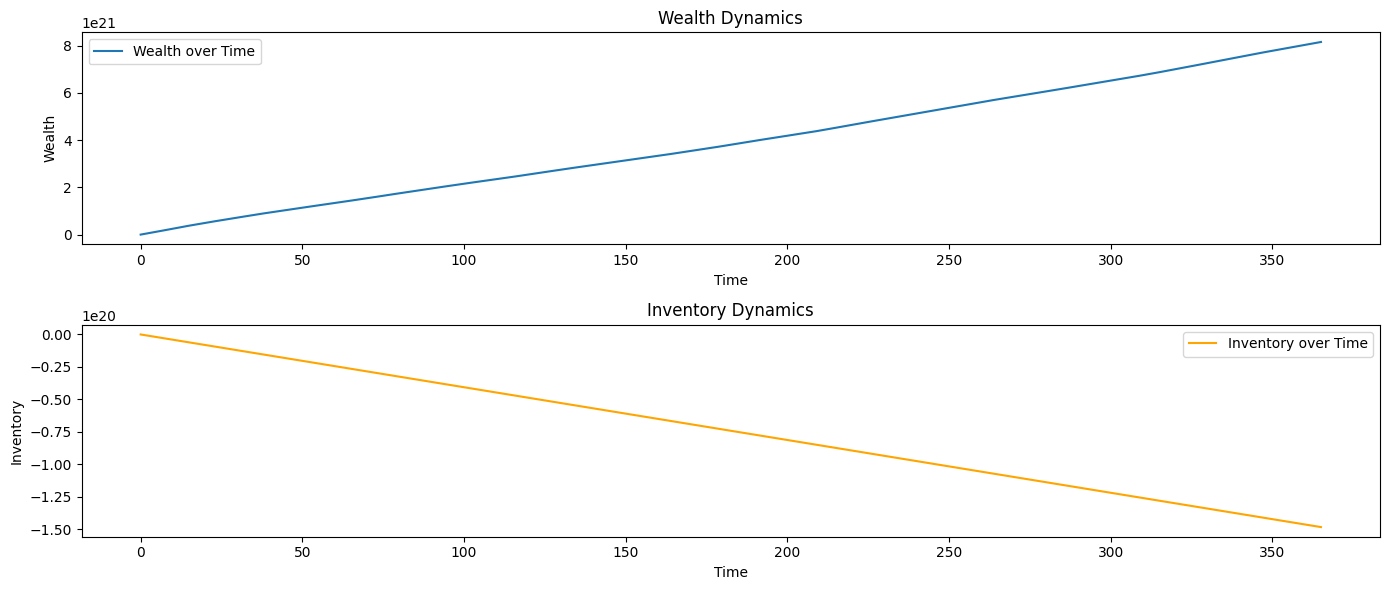

In [6]:
# Run the simulation for limit orders
time_points, wealth, inventory = simulate_limit_orders(S, sigma, gamma, x, q=1, T=T, dt=dt)

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(time_points, wealth, label='Wealth over Time')
plt.title('Wealth Dynamics')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_points, inventory, label='Inventory over Time', color='orange')
plt.title('Inventory Dynamics')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.legend()

plt.tight_layout()
plt.show()